 What is Naive Bayes and why is it used instead of Logistic Regression?

Naive Bayes is a probabilistic classification algorithm based on Bayes’ theorem that assumes feature independence. It is widely used for text classification because it is fast, works well with high-dimensional data, and performs effectively even with small datasets. Logistic regression is preferred when large datasets are available and feature relationships are important.

In [1]:
import pandas as pd

In [2]:
df =pd.read_csv("emails.csv")

In [3]:
df.sample()

,text,spam
5668,Subject: poten & partners forecasts fyi marg ...,0


In [4]:
df

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


In [5]:
df.isnull().value_counts()

text   spam 
False  False    5728
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words="english",
                        max_features=5000
                       )
X_text= tfidf.fit_transform(df['text'])
y= df['spam']


This code is manually creating extra features from email text.

In [8]:
import numpy as np

df['exclamation_count'] = df['text'].str.count('!')
df['all_caps'] = df['text'].str.contains(r'[A-Z]{5,}', regex=True).astype(int)
df['spam_words'] = df['text'].str.contains(
    r'free|win|winner|cash|prize|urgent',
    case=False,
    regex=True
).astype(int)

X_extra = df[['exclamation_count', 'all_caps', 'spam_words']].values


It combines two different types of features into one final dataset that the model can learn from. 
Feature Set	Type
X_text	Sparse matrix
X_extra	Dense NumPy array 

so we not add it directly

### What Does hstack Mean?

Horizontal stack (column-wise merge)

It means:

Keep the same number of rows

Add columns side-by-side

In [9]:
X_text.shape


(5728, 5000)

In [10]:
X_extra.shape

(5728, 3)

In [11]:
from scipy.sparse import hstack

X = hstack([X_text, X_extra])


In [12]:
X.shape

(5728, 5003)

### Why Use scipy.sparse.hstack?

Because:
X_text is sparse
Using NumPy would convert it to dense
That would waste huge memory
hstack keeps everything sparse and efficient. 

hstack is used to horizontally combine sparse text features with additional numerical features while preserving memory efficiency.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X_train , X_test ,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train)

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


### MultinomialNB (Multinomial Naive Bayes)
is a specific type of Naive Bayes algorithm in machine learning designed for classification tasks, particularly in Natural Language Processing (NLP), where the input features represent counts or frequencies of events (such as word counts in a document). It is particularly effective for text categorization. 

In [15]:
n_text_features = X_text.shape[1]
n_extra_features = X_extra.shape[1]

print(n_text_features, n_extra_features)


5000 3


In [16]:
feature_names = tfidf.get_feature_names_out()

# Only probabilities for text features
spam_probs_text = model.feature_log_prob_[1][:n_text_features]

top_spam_words = np.argsort(spam_probs_text)[-15:]

for i in top_spam_words:
    print(feature_names[i])


best
just
free
company
email
online
business
http
com
money
website
save
click
software
subject


In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
y_pred = model.predict(X_test)


print('Accuracy:', round(accuracy_score(y_test,y_pred),3)*100,f'%')
print("------------------------------------------")
print("-----------MULTINOMIAL NAIVE BAYES---------------")

cm1= confusion_matrix(y_test ,y_pred)
print(f'Confusion matrix is :- \n {cm1}')
cl = classification_report(y_test, y_pred)
print(f'Classification report of spam email analysis is : \n {cl}')

Accuracy: 96.6 %
------------------------------------------
-----------MULTINOMIAL NAIVE BAYES---------------
Confusion matrix is :- 
 [[845  11]
 [ 28 262]]
Classification report of spam email analysis is : 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       856
           1       0.96      0.90      0.93       290

    accuracy                           0.97      1146
   macro avg       0.96      0.95      0.95      1146
weighted avg       0.97      0.97      0.97      1146



In [18]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)


In [36]:
print('Accuracy:', round(accuracy_score(y_test,lr_pred),3)*100,f'%')
print("------------------------------------------")
print("-----------LOGISTIC REGRESSION---------------")

cm2= confusion_matrix(y_test ,lr_pred)
print(f'Confusion matrix is :- \n {cm2}')
cl = classification_report(y_test, lr_pred)
print(f'Classification report of spam email analysis is : \n {cl}')

Accuracy: 96.89999999999999 %
------------------------------------------
-----------LOGISTIC REGRESSION---------------
Confusion matrix is :- 
 [[853   3]
 [ 32 258]]
Classification report of spam email analysis is : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       856
           1       0.99      0.89      0.94       290

    accuracy                           0.97      1146
   macro avg       0.98      0.94      0.96      1146
weighted avg       0.97      0.97      0.97      1146



In [20]:
def predict_email(text):
    text_vec = tfidf.transform([text])
    extra = np.array([[text.count('!'),
                       int(bool(re.search(r'[A-Z]{5,}', text))),
                       int(bool(re.search(r'free|win|cash|urgent', text.lower())))]])
    
    X_combined = hstack([text_vec, extra])
    prob = model.predict_proba(X_combined)[0][1]

    return f"Spam Probability: {prob:.2f}"


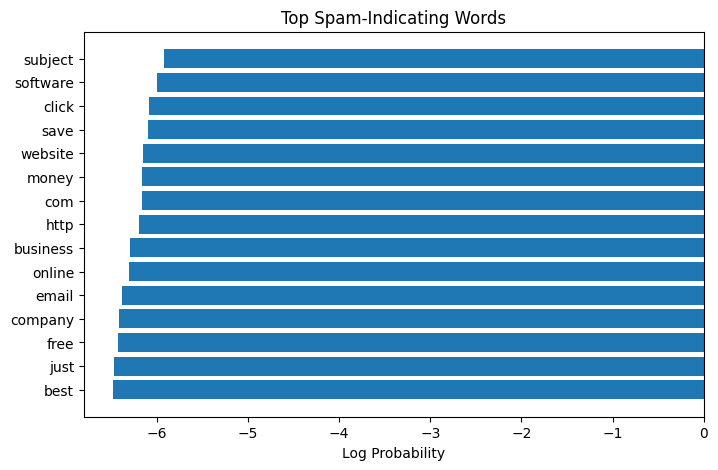

In [24]:
import matplotlib.pyplot as plt

top_words = feature_names[top_spam_words]
top_probs = spam_probs_text[top_spam_words]

plt.figure(figsize=(8,5))
plt.barh(top_words, top_probs)
plt.xlabel("Log Probability")
plt.title("Top Spam-Indicating Words")
plt.show()


In [25]:
import seaborn as sns 

C:\Users\Sumit\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


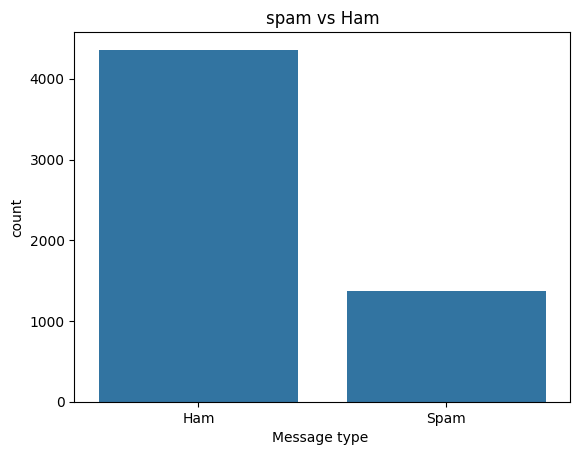

In [31]:
sns.countplot(x='spam', data=df)
plt.title("spam vs Ham")
plt.xlabel("Message type ")
plt.xticks([0, 1], ['Ham', 'Spam']) 
plt.show()

Text(0.5, 1.0, 'Naive Bayes')

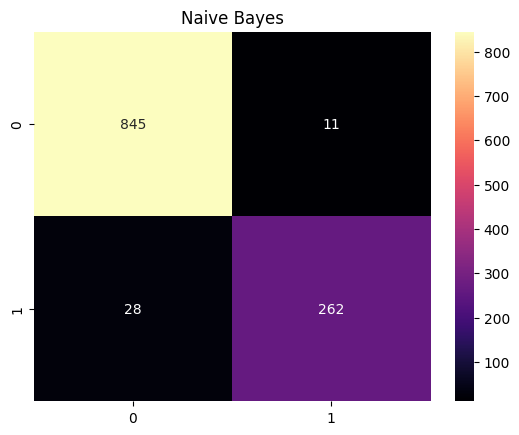

In [44]:
sns.heatmap(cm1, annot=True,fmt='d', cmap='magma')
plt.title("Naive Bayes")

Text(0.5, 1.0, 'Logistic Regression')

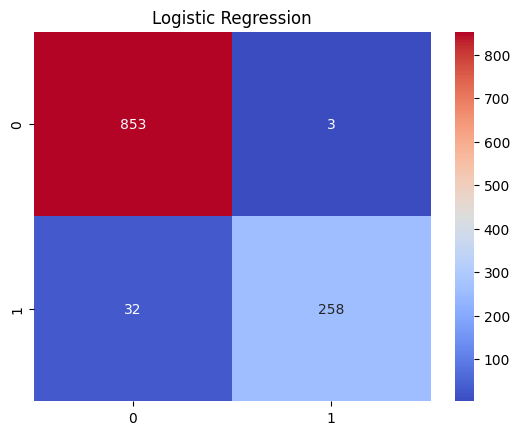

In [42]:
sns.heatmap(cm2, annot=True,fmt='d', cmap='coolwarm')
plt.title("Logistic Regression")

C:\Users\Sumit\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='spam', ylabel='exclamation_count'>

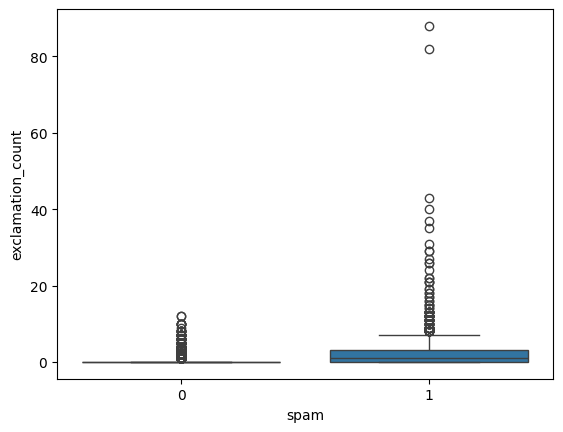

In [40]:
sns.boxplot(x='spam', y='exclamation_count', data=df)


In [45]:
def predict_spam(email_text):
    text_features = tfidf.transform([email_text])

    
    extra_features = np.array([[
        email_text.count('!'),
        int(bool(__import__('re').search(r'[A-Z]{5,}', email_text))),
        int(bool(__import__('re').search(
            r'free|win|winner|cash|prize|urgent',
            email_text.lower()
        )))
    ]])

    combined = hstack([text_features, extra_features])
    prob = model.predict_proba(combined)[0][1]

    return prob

email = "URGENT! You have WON a FREE prize!!!"
print("Spam probability:", round(predict_spam(email),3)*100 ,f'%')


Spam probability: 99.8 %


In [47]:
email = "Subject: re : research and development charges.."
print("Spam probability:", round(predict_spam(email),3)*100 ,f'%')

Spam probability: 2.3 %


In [48]:
import joblib

joblib.dump(model, "spam_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [49]:
import sklearn
print(sklearn.__version__)


1.8.0
